In [25]:
library(qiime2R)
library(phyloseq)
library(microViz)
library(tidyverse) ; packageVersion("tidyverse")
library(ggpubr)
library("RColorBrewer")

[1] ‘2.0.0’

In [2]:
colors <- c("#FAD02E", "#F28D35", "#DA5724", "#C52E6D", "#D14285",
"#AD6F3B", "#6B5B95", "#8569D5", "#6F8FAF", "#5F7FC7",
"#56B4E9", "#40B5AD", "#8A7C64", "#CBD588", "#5E738F",
"#673770", "#006700", "#CD9BCD", "#D1A33D", "#D14285",
"#FAD02E", "#F28D35", "#C52E6D", "#6B5B95", "grey", "#AD6F3B",
 "#56B4E9", "#40B5AD", "#CBD588",
"#5E738F", "#673770", "#006700", "#CD9BCD", "#D1A33D",
"#FAD02E", "#F28D35", "#C52E6D", "#6B5B95", "#AD6F3B",
"#6F8FAF", "#8A7C64", "#56B4E9")

In [3]:
#list of ASVs previously found associated with SCTLD
pathID = scan("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/pathIds.txt",
                what = "", quiet=TRUE) 
head(pathID)


[1] "0036a402829562115899284c8a26a800" "00ac46bacb5e2de442857f0969b3b198"
[3] "01579fdd97b1f685abfb5e352cd2d615" "017a88c8350a114ea8e5f468ad2e600b"
[5] "017b84b388e37179c25d91efeff999bf" "01a1466ad844b0d1ceddcad63732afd5"

In [4]:
#read metadata file and set factor order
meta = read.csv("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/metadata/meta_EPA2.csv",
               header=TRUE, row.names=1)
meta$Site_Num <- as.integer(meta$Site_Num)
meta$Site.Status <- factor(meta$Site.Status, levels = c("Vulnerable",
                                                         "Epidemic","Endemic"))

meta$Type <- factor(meta$Type, levels = c("Water","Coral","Sediment"))

head(meta, n=2)
dim(meta)

,samp,Sample.ID,Site,Site.Name,Region,Project,Type,Species_sample,Sample.Type,Site.Status,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
518.H,518.H_S18,518.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,Coral,OFAV,Healthy,Vulnerable,⋯,0,1,0,0,0,0,0,0,0,0
519.H,519.H_S18,519.H_S18,Site-G,Xesto.Patch,Lower Keys,SWG,Coral,OFAV,Healthy,Vulnerable,⋯,0,1,0,0,0,0,0,0,0,0


[1] 360  45

In [5]:
#read ASV table
ASV_qza <- read_qza("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/merged_tables_BacArc_fill_EPA2.qza")
ASV_table <- ASV_qza$data
head(ASV_table, n=2)
dim(ASV_table)

,R1.1.W,R1.10.W,R1.11.W,R1.12.W,R1.13.W,R1.14.W,R1.15.W,R1.16.W,R1.17.W,R1.18.W,⋯,GR.SINT.En4,GR.SINT.En5,GR.SINT.En6,TP.DLAB.En1,TP.DLAB.En2,TP.DLAB.En3,TP.DLAB.En4,TP.DLAB.En5,TP.DLAB.En6,TP.DSTO.En1
72caa013fe7649c65ffe72138ff7dfd1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2b248f10cca3c82a2640506132f9c869,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 11756  1109

In [6]:
taxa_qza <- read_qza("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/tax_EPA2.qza")
taxa_table <- taxa_qza$data
taxa_table <- taxa_qza$data %>%
as_tibble() %>% 
separate(Taxon, sep=";", c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")) %>%
arrange(Feature.ID) %>%
mutate(ASVs =paste('ASV',1:n(), sep = "_")) %>%
column_to_rownames("Feature.ID")%>%

as.matrix()

Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 103262 rows [1, 2, 3, 7,
8, 9, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 24, 26, 27, ...].”


In [7]:
ps = phyloseq(otu_table(ASV_table, taxa_are_rows=TRUE), 
               sample_data(meta),
tax_table(taxa_table))
#

ps_AH <- subset_samples(ps, Sample.Type=="Healthy")
ps_AH

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11756 taxa and 117 samples ]
sample_data() Sample Data:       [ 117 samples by 45 sample variables ]
tax_table()   Taxonomy Table:    [ 11756 taxa by 9 taxonomic ranks ]

In [8]:
# Subset samples for Sediment type
ps_Sediment <- subset_samples(ps, subset = sample_data(ps)$Type == "Sediment")

ps_Water <- subset_samples(ps, subset = sample_data(ps)$Type == "Water")


In [9]:
ps_merged=merge_phyloseq(ps_Sediment,ps_Water, ps_AH)
ps_merged

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11756 taxa and 303 samples ]
sample_data() Sample Data:       [ 303 samples by 45 sample variables ]
tax_table()   Taxonomy Table:    [ 11756 taxa by 9 taxonomic ranks ]

In [10]:
#filter to select SCTLD-associated bacteria 
allTaxa = taxa_names(ps_merged)
allTaxa <- allTaxa[(allTaxa %in% pathID)]
ps_path = prune_taxa(allTaxa, ps_merged)
ps_path

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 82 taxa and 303 samples ]
sample_data() Sample Data:       [ 303 samples by 45 sample variables ]
tax_table()   Taxonomy Table:    [ 82 taxa by 9 taxonomic ranks ]

## Figure 8

In [11]:
sum_ps=ps_path %>%
  tax_glom(taxrank = "ASVs") %>%
  transform_sample_counts(function(x) {x/sum(x)} ) %>% # Transform to rel. abundance
  psmelt()
colnames(sum_ps)

[1] "OTU"                "Sample"             "Abundance"         
 [4] "samp"               "Sample.ID"          "Site"              
 [7] "Site.Name"          "Region"             "Project"           
[10] "Type"               "Species_sample"     "Sample.Type"       
[13] "Site.Status"        "Month"              "Year"              
[16] "Site_Num"           "Date"               "collection_date"   
[19] "Lat"                "Long"               "lat_lon"           
[22] "SST_jplMURSST41"    "Season"             "organism"          
[25] "geo_loc_name"       "env_local_scale"    "env_broad_scale"   
[28] "env_medium"         "waterBody"          "countryCode"       
[31] "amplicon_sequenced" "Vulnerable"         "Epidemic"          
[34] "Endemic"            "Sediment"           "Coral"             
[37] "Water"              "Zone"               "Types"             
[40] "Vul_coral"          "End_coral"          "Epi_coral"         
[43] "Vul_sed"            "End_sed"            "Epi_sed"           
[46] "Vul_wat"            "End_wat"            "Epi_wat"           
[49] "Kingdom"            "Phylum"             "Class"             
[52] "Order"              "Family"             "Genus"             
[55] "Species"            "Confidence"         "ASVs"

Warning message:
“Removed 255 rows containing missing values or values outside the scale range
(`geom_bar()`).”


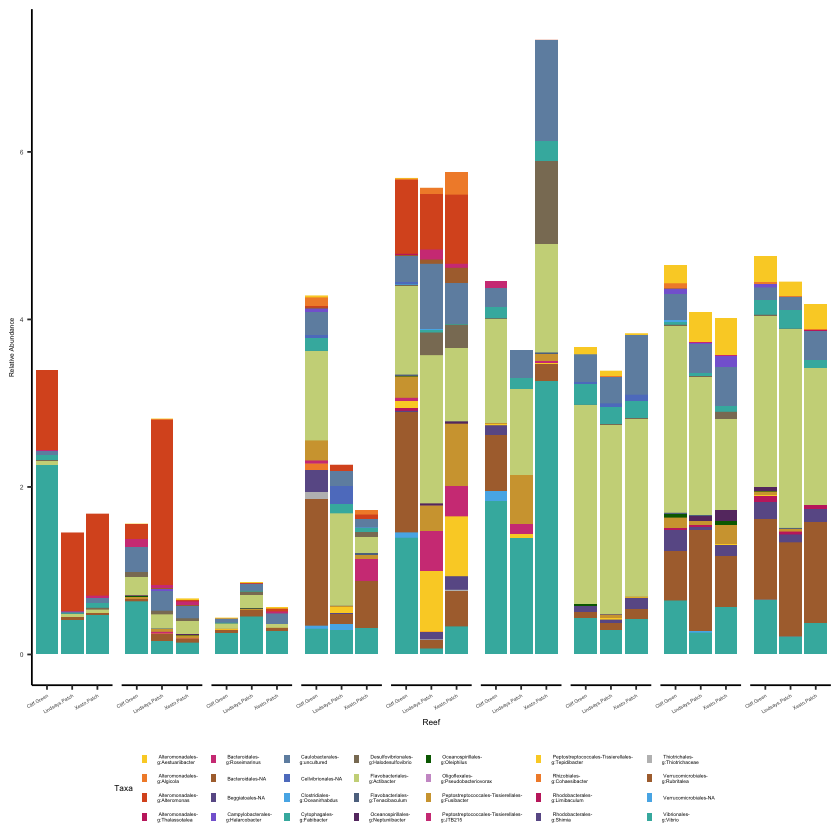

In [12]:
# Convert Type to a factor with specified levels
sum_ps$Type <- factor(sum_ps$Type, levels = c("Water", "Coral", "Sediment"))

# Create the bar plot
fig_bar_path <- sum_ps %>%
  unite("Taxa", Order, Genus, remove = FALSE, sep = "-") %>%
  filter(Taxa != " o__Rhodobacterales-NA") %>%
  mutate(across(where(is.character), ~ str_replace_all(.x, "o__", ""))) %>%
  mutate(across(where(is.character), ~ str_replace_all(.x, "g__", "\ng:"))) %>%
  ggplot(aes(x = Site.Name, y = Abundance, fill = Taxa)) +
  geom_bar(stat = "identity", position = "stack") +
  facet_grid(. ~ Type + Site.Status) +
  scale_fill_manual(values = colors) +
  theme_classic() +
  theme(
    legend.text = element_text(size = 3),
    legend.title = element_text(size = 5),
    legend.position = "bottom",
    axis.title.x = element_text(size = 5),
    axis.title.y = element_text(size = 4),
    axis.text.x = element_text(size = 3, angle = 30, hjust = 1),
    axis.text.y = element_text(size = 4),
    strip.background = element_blank(),
    strip.text.x = element_blank(),
    strip.text = element_text(size = 5, face = "bold")
  ) +
  guides(
    fill = guide_legend(keywidth = 0.3, keyheight = 0.35, ncol = 9),
    shape = "none"
  ) +
  xlab("Reef") +
  ylab("Relative Abundance")

fig_bar_path


In [13]:
ps_path_fill= filter_taxa(ps_path, function(x) sum(x > 0) > (0.0*length(x)), TRUE) 

                          
ps_path 
microbiome::summarize_phyloseq(ps_path)
ps_path_fill
microbiome::summarize_phyloseq(ps_path_fill)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 82 taxa and 303 samples ]
sample_data() Sample Data:       [ 303 samples by 45 sample variables ]
tax_table()   Taxonomy Table:    [ 82 taxa by 9 taxonomic ranks ]

Compositional = NO2

1] Min. number of reads = 02] Max. number of reads = 173593] Total number of reads = 3892324] Average number of reads = 1284.594059405945] Median number of reads = 9527] Sparsity = 0.8725750623842876] Any OTU sum to 1 or less? YES8] Number of singletons = 99] Percent of OTUs that are singletons 
        (i.e. exactly one read detected across all samples)010] Number of sample variables are: 45sampSample.IDSiteSite.NameRegionProjectTypeSpecies_sampleSample.TypeSite.StatusMonthYearSite_NumDatecollection_dateLatLonglat_lonSST_jplMURSST41Seasonorganismgeo_loc_nameenv_local_scaleenv_broad_scaleenv_mediumwaterBodycountryCodeamplicon_sequencedVulnerableEpidemicEndemicSedimentCoralWaterZoneTypesVul_coralEnd_coralEpi_coralVul_sedEnd_sedEpi_sedVul_watEnd_watEpi_wat2



[[1]]
[1] "1] Min. number of reads = 0"

[[2]]
[1] "2] Max. number of reads = 17359"

[[3]]
[1] "3] Total number of reads = 389232"

[[4]]
[1] "4] Average number of reads = 1284.59405940594"

[[5]]
[1] "5] Median number of reads = 952"

[[6]]
[1] "7] Sparsity = 0.872575062384287"

[[7]]
[1] "6] Any OTU sum to 1 or less? YES"

[[8]]
[1] "8] Number of singletons = 9"

[[9]]
[1] "9] Percent of OTUs that are singletons \n        (i.e. exactly one read detected across all samples)0"

[[10]]
[1] "10] Number of sample variables are: 45"

[[11]]
 [1] "samp"               "Sample.ID"          "Site"              
 [4] "Site.Name"          "Region"             "Project"           
 [7] "Type"               "Species_sample"     "Sample.Type"       
[10] "Site.Status"        "Month"              "Year"              
[13] "Site_Num"           "Date"               "collection_date"   
[16] "Lat"                "Long"               "lat_lon"           
[19] "SST_jplMURSST41"    "Season"             "organism"          
[22] "geo_loc_name"       "env_local_scale"    "env_broad_scale"   
[25] "env_medium"         "waterBody"          "countryCode"       
[28] "amplicon_sequenced" "Vulnerable"         "Epidemic"          
[31] "Endemic"            "Sediment"           "Coral"             
[34] "Water"              "Zone"               "Types"             
[37] "Vul_coral"          "End_coral"          "Epi_coral"         
[40] "Vul_sed"            "End_sed"            "Epi_sed"           
[43] "Vul_wat"            "End_wat"            "Epi_wat"

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 73 taxa and 303 samples ]
sample_data() Sample Data:       [ 303 samples by 45 sample variables ]
tax_table()   Taxonomy Table:    [ 73 taxa by 9 taxonomic ranks ]

Compositional = NO2

1] Min. number of reads = 02] Max. number of reads = 173593] Total number of reads = 3892324] Average number of reads = 1284.594059405945] Median number of reads = 9527] Sparsity = 0.8568651385686516] Any OTU sum to 1 or less? NO8] Number of singletons = 09] Percent of OTUs that are singletons 
        (i.e. exactly one read detected across all samples)010] Number of sample variables are: 45sampSample.IDSiteSite.NameRegionProjectTypeSpecies_sampleSample.TypeSite.StatusMonthYearSite_NumDatecollection_dateLatLonglat_lonSST_jplMURSST41Seasonorganismgeo_loc_nameenv_local_scaleenv_broad_scaleenv_mediumwaterBodycountryCodeamplicon_sequencedVulnerableEpidemicEndemicSedimentCoralWaterZoneTypesVul_coralEnd_coralEpi_coralVul_sedEnd_sedEpi_sedVul_watEnd_watEpi_wat2



[[1]]
[1] "1] Min. number of reads = 0"

[[2]]
[1] "2] Max. number of reads = 17359"

[[3]]
[1] "3] Total number of reads = 389232"

[[4]]
[1] "4] Average number of reads = 1284.59405940594"

[[5]]
[1] "5] Median number of reads = 952"

[[6]]
[1] "7] Sparsity = 0.856865138568651"

[[7]]
[1] "6] Any OTU sum to 1 or less? NO"

[[8]]
[1] "8] Number of singletons = 0"

[[9]]
[1] "9] Percent of OTUs that are singletons \n        (i.e. exactly one read detected across all samples)0"

[[10]]
[1] "10] Number of sample variables are: 45"

[[11]]
 [1] "samp"               "Sample.ID"          "Site"              
 [4] "Site.Name"          "Region"             "Project"           
 [7] "Type"               "Species_sample"     "Sample.Type"       
[10] "Site.Status"        "Month"              "Year"              
[13] "Site_Num"           "Date"               "collection_date"   
[16] "Lat"                "Long"               "lat_lon"           
[19] "SST_jplMURSST41"    "Season"             "organism"          
[22] "geo_loc_name"       "env_local_scale"    "env_broad_scale"   
[25] "env_medium"         "waterBody"          "countryCode"       
[28] "amplicon_sequenced" "Vulnerable"         "Epidemic"          
[31] "Endemic"            "Sediment"           "Coral"             
[34] "Water"              "Zone"               "Types"             
[37] "Vul_coral"          "End_coral"          "Epi_coral"         
[40] "Vul_sed"            "End_sed"            "Epi_sed"           
[43] "Vul_wat"            "End_wat"            "Epi_wat"

In [14]:
ps_rare <- phyloseq::rarefy_even_depth(ps_path_fill, rngseed = 123, replace = FALSE, sample.size=50)  

`set.seed(123)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(123); .Random.seed` for the full vector

...

13 samples removedbecause they contained fewer reads than `sample.size`.

Up to first five removed samples are: 


523.H538.HXP.MCAV2.HXP.MCAV6.HLP.MCAV.En1

...

3OTUs were removed because they are no longer 
present in any sample after random subsampling


...



In [15]:
adiv <- data.frame(
    phyloseq::estimate_richness(ps_path, measures=c("Observed", "InvSimpson", "Shannon")))  %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "X5",
                replacement = "5") 

head(adiv) 
dim(adiv)

,Observed,Shannon,InvSimpson
,<dbl>,<dbl>,<dbl>
R3.1.S,12,1.869107,5.017691
R3.10.S,13,1.811089,4.387743
R3.11.S,17,2.080899,5.538322
R3.12.S,14,1.825823,4.254988
R3.13.S,13,1.930065,4.763786
R3.14.S,15,2.083861,5.609061


[1] 303   3

In [16]:
#combine data with enviornmental data
adiv_meta1= as(sample_data(ps_path_fill), "data.frame") 

adiv_meta=adiv_meta1 %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "X5", replacement = "5") 

head(adiv_meta)

,samp,Sample.ID,Site,Site.Name,Region,Project,Type,Species_sample,Sample.Type,Site.Status,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
R3.1.S,R3.1.S_S13,R3.1.S_S13,NA,Cliff.Green,Lower Keys,EPA1,Sediment,Sediment,NA,Vulnerable,⋯,3,0,0,0,1,0,0,0,0,0
R3.10.S,R3.10.S_S13,R3.10.S_S13,NA,Cliff.Green,Lower Keys,EPA1,Sediment,Sediment,NA,Vulnerable,⋯,3,0,0,0,1,0,0,0,0,0
R3.11.S,R3.11.S_S13,R3.11.S_S13,Site-G,Xesto.Patch,Lower Keys,EPA1,Sediment,Sediment,NA,Vulnerable,⋯,3,0,0,0,1,0,0,0,0,0
R3.12.S,R3.12.S_S13,R3.12.S_S13,Site-G,Xesto.Patch,Lower Keys,EPA1,Sediment,Sediment,NA,Vulnerable,⋯,3,0,0,0,1,0,0,0,0,0
R3.13.S,R3.13.S_S13,R3.13.S_S13,Site-G,Xesto.Patch,Lower Keys,EPA1,Sediment,Sediment,NA,Vulnerable,⋯,3,0,0,0,1,0,0,0,0,0
R3.14.S,R3.14.S_S13,R3.14.S_S13,Site-G,Xesto.Patch,Lower Keys,EPA1,Sediment,Sediment,NA,Vulnerable,⋯,3,0,0,0,1,0,0,0,0,0


In [17]:
alpha_envs_path=cbind(adiv, adiv_meta)

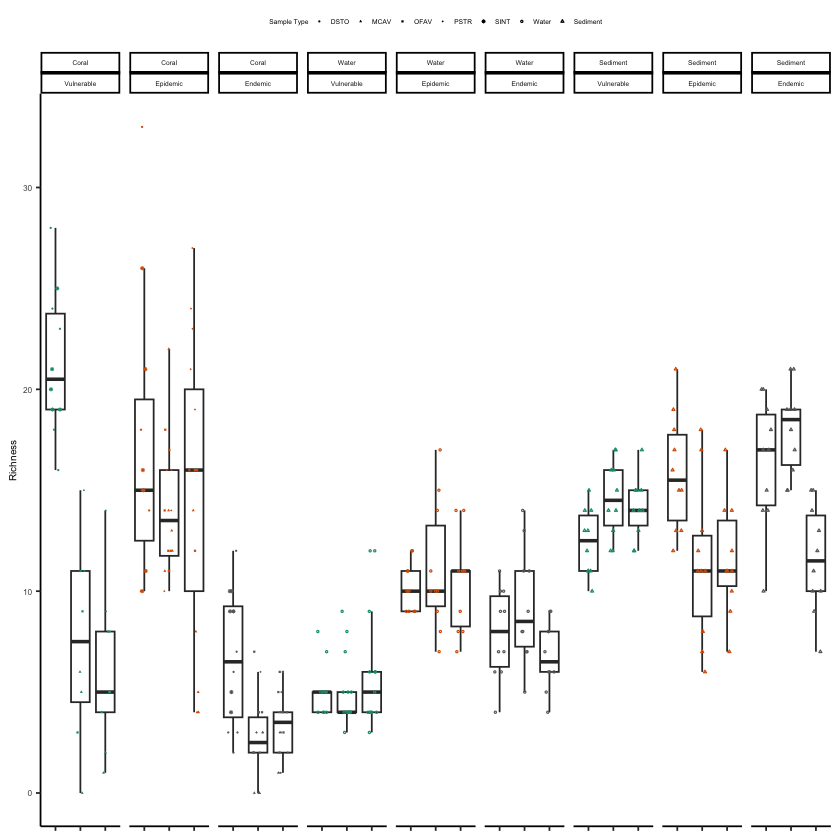

In [18]:
# Define shape mapping for species and sample types
shape_mapping <- c(
  "DSTO" = 16, "MCAV" = 17, "OFAV" = 15, "PSTR" = 18, "SINT" = 8,
  "Sediment" = 2, "Water" = 1
)

# Clean and structure data
adiv <- adiv %>%
  mutate_if(is.character, stringr::str_replace_all, pattern = "X5", replacement = "5")

# Merge diversity data with metadata
alpha_envs_path <- cbind(adiv, adiv_meta)
alpha_envs_path$Type <- factor(alpha_envs_path$Type, levels = c("Coral", "Water", "Sediment"))

alpha_envs_path$Species_sample <- factor(
  alpha_envs_path$Species_sample,
  levels = c("DSTO", "MCAV", "OFAV", "PSTR", "SINT", "Water", "Sediment")
)

# Define color palette
cbPalette <- c("#009E73", "#D55E00", "#696969")

# Create alpha diversity plot
alpha_paths <- ggplot(alpha_envs_path, aes(x = Site.Name, y = Observed)) +
  geom_boxplot(outlier.color = NA) +
  geom_jitter(aes(color = Site.Status, shape = Species_sample), 
              size = 0.3, height = 0, width = 0.2) +
  labs(x = "Reefs", y = "Richness") +
  scale_color_manual(values = cbPalette) +
  scale_shape_manual(values = shape_mapping) +
  theme_classic() +
  theme(
    legend.position = "top",
    legend.text = element_text(size = 4),
    legend.title = element_text(size = 4),
    axis.title.y = element_text(size = 6),
    axis.text.y = element_text(size = 5),
    axis.text.x = element_blank(),
    axis.title.x = element_blank(),
    strip.text = element_text(size = 4)
  ) +
  facet_grid(. ~ Type + Site.Status) +
  guides(
    fill = "none",
    color = "none",
    shape = guide_legend(keywidth = 0.2, keyheight = 0.25, nrow = 1, title = "Sample Type")
  )

alpha_paths


Warning message:
“Removed 255 rows containing missing values or values outside the scale range
(`geom_bar()`).”


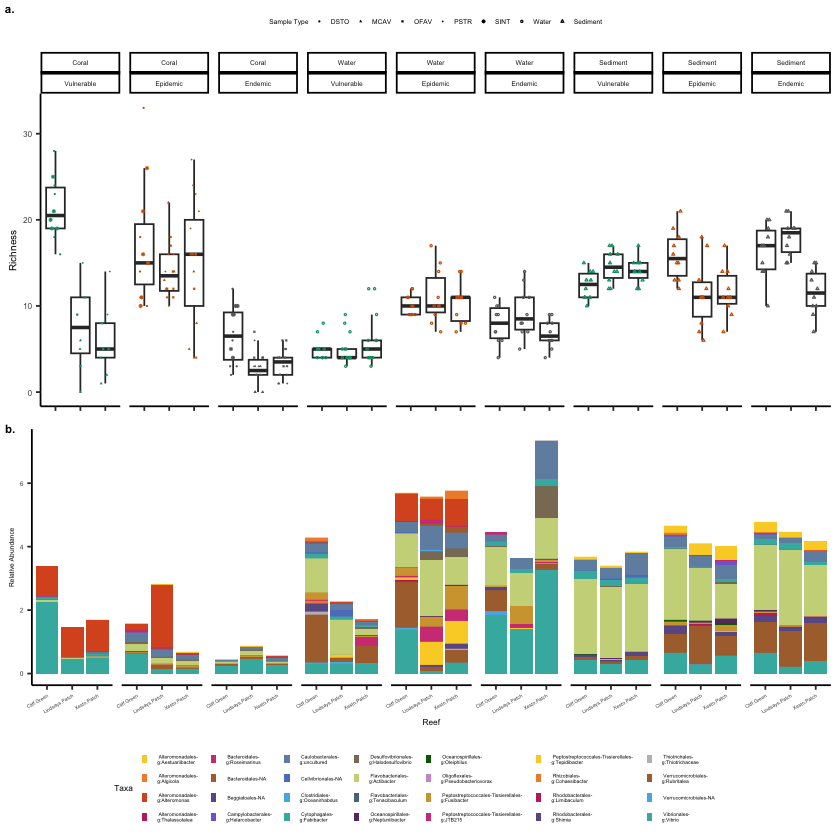

In [19]:

figs_paths=ggarrange(alpha_paths,fig_bar_path, nrow = 2, ncol=1, common.legend = FALSE,
                           labels = c("a.","b."), heights = c(1, 1), 
                     #label.x=-0.03,
                       font.label = list(size = 7, color = "black")

                    
                    )

figs_paths
ggsave("/Users/stephanie.rosales/Documents/Tissueloss/EPA2/Figures/Figure8.png",
     width = 5.5, height =4, units = "in", dpi=300)

In [20]:
#combine data with enviornmental data
adiv_meta1= as(sample_data(ps_path_fill), "data.frame") 

adiv_meta=adiv_meta1 %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "X5", replacement = "5") 

head(adiv_meta)

,samp,Sample.ID,Site,Site.Name,Region,Project,Type,Species_sample,Sample.Type,Site.Status,⋯,Types,Vul_coral,End_coral,Epi_coral,Vul_sed,End_sed,Epi_sed,Vul_wat,End_wat,Epi_wat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<fct>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
R3.1.S,R3.1.S_S13,R3.1.S_S13,NA,Cliff.Green,Lower Keys,EPA1,Sediment,Sediment,NA,Vulnerable,⋯,3,0,0,0,1,0,0,0,0,0
R3.10.S,R3.10.S_S13,R3.10.S_S13,NA,Cliff.Green,Lower Keys,EPA1,Sediment,Sediment,NA,Vulnerable,⋯,3,0,0,0,1,0,0,0,0,0
R3.11.S,R3.11.S_S13,R3.11.S_S13,Site-G,Xesto.Patch,Lower Keys,EPA1,Sediment,Sediment,NA,Vulnerable,⋯,3,0,0,0,1,0,0,0,0,0
R3.12.S,R3.12.S_S13,R3.12.S_S13,Site-G,Xesto.Patch,Lower Keys,EPA1,Sediment,Sediment,NA,Vulnerable,⋯,3,0,0,0,1,0,0,0,0,0
R3.13.S,R3.13.S_S13,R3.13.S_S13,Site-G,Xesto.Patch,Lower Keys,EPA1,Sediment,Sediment,NA,Vulnerable,⋯,3,0,0,0,1,0,0,0,0,0
R3.14.S,R3.14.S_S13,R3.14.S_S13,Site-G,Xesto.Patch,Lower Keys,EPA1,Sediment,Sediment,NA,Vulnerable,⋯,3,0,0,0,1,0,0,0,0,0


## Relative abundance

In [21]:
library("data.table")
fast_melt = function(physeq){
  # supports "naked" otu_table as `physeq` input.
  otutab = as(otu_table(physeq), "matrix")
  if(!taxa_are_rows(physeq)){otutab <- t(otutab)}
  otudt = data.table(otutab, keep.rownames = TRUE)
  setnames(otudt, "rn", "taxaID")
  # Enforce character taxaID key
  otudt[, taxaIDchar := as.character(taxaID)]
  otudt[, taxaID := NULL]
  setnames(otudt, "taxaIDchar", "taxaID")
  # Melt count table
  mdt = melt.data.table(otudt, 
                        id.vars = "taxaID",
                        variable.name = "SampleID",
                        value.name = "count")
  # Remove zeroes, NAs
  mdt <- mdt[count > 0][!is.na(count)]
  # Calculate relative abundance
  mdt[, RelativeAbundance := count / sum(count), by = SampleID]
  if(!is.null(tax_table(physeq, errorIfNULL = FALSE))){
    # If there is a tax_table, join with it. Otherwise, skip this join.
    taxdt = data.table(as(tax_table(physeq, errorIfNULL = TRUE), "matrix"), keep.rownames = TRUE)
    setnames(taxdt, "rn", "taxaID")
    # Enforce character taxaID key
    taxdt[, taxaIDchar := as.character(taxaID)]
    taxdt[, taxaID := NULL]
    setnames(taxdt, "taxaIDchar", "taxaID")
    # Join with tax table
    setkey(taxdt, "taxaID")
    setkey(mdt, "taxaID")
    mdt <- taxdt[mdt]
  }
  return(mdt)
}

summarize_taxa = function(physeq, Rank, GroupBy = NULL){
  Rank <- Rank[1]
  if(!Rank %in% rank_names(physeq)){
    message("The argument to `Rank` was:\n", Rank,
            "\nBut it was not found among taxonomic ranks:\n",
            paste0(rank_names(physeq), collapse = ", "), "\n",
            "Please check the list shown above and try again.")
  }
  if(!is.null(GroupBy)){
    GroupBy <- GroupBy[1]
    if(!GroupBy %in% sample_variables(physeq)){
      message("The argument to `GroupBy` was:\n", GroupBy,
              "\nBut it was not found among sample variables:\n",
              paste0(sample_variables(physeq), collapse = ", "), "\n",
              "Please check the list shown above and try again.")
    }
  }
  # Start with fast melt
  mdt = fast_melt(physeq)
  if(!is.null(GroupBy)){
    # Add the variable indicated in `GroupBy`, if provided.
    sdt = data.table(SampleID = sample_names(physeq),
                     var1 = get_variable(physeq, GroupBy))
    setnames(sdt, "var1", GroupBy)
    # Join
    setkey(sdt, SampleID)
    setkey(mdt, SampleID)
    mdt <- sdt[mdt]
  }
  # Summarize
Nsamples = nsamples(physeq)
  summarydt = mdt[, list(meanRA = (mean(RelativeAbundance))*100,
                         sdRA = sd(RelativeAbundance)*100,
                         minRA = min(RelativeAbundance)*100,
                         maxRA = max(RelativeAbundance)*100),
                  by = c(Rank, GroupBy)]
  return(summarydt)
}


Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




In [22]:
subset_samples(ps_path_fill, Type=="Coral") %>%
summarize_taxa(Rank="Order", GroupBy="Site.Status") %>%
#filter(Order %in% c(' o__Alteromonadales')) %>%
arrange(-meanRA)  %>%
head()

Order,Site.Status,meanRA,sdRA,minRA,maxRA
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
o__Rhodobacterales,Endemic,31.51797,27.91757,0.4266492,100.00000
o__Vibrionales,Endemic,30.89929,32.22347,1.1320755,94.35510
o__Desulfovibrionales,Endemic,20.20505,32.54821,0.8771930,77.83985
o__Caulobacterales,Endemic,17.74896,29.78958,1.0554090,100.00000
o__Rhodobacterales,Vulnerable,14.06565,19.74631,0.1969561,100.00000
o__Flavobacteriales,Endemic,13.24744,13.52530,0.6435467,51.35135


In [23]:
subset_samples(ps_path_fill, Type=="Water") %>%
summarize_taxa(Rank="Order", GroupBy="Site.Status") %>%
#filter(Order %in% c(' o__Peptostreptococcales-Tissierellales')) %>%
arrange(-meanRA) %>%
head()

Order,Site.Status,meanRA,sdRA,minRA,maxRA
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
o__Rhodobacterales,Vulnerable,32.027497,20.61688,1.3148789,87.31661
o__Rhodobacterales,Endemic,25.579666,35.81911,0.5113221,90.14634
o__Rhodobacterales,Epidemic,19.809250,28.07505,0.4034291,82.96060
o__Vibrionales,Vulnerable,15.736169,11.49687,1.8099548,44.24460
o__Alteromonadales,Vulnerable,8.216693,6.04785,0.4127967,27.98507
o__Alteromonadales,Epidemic,7.381433,16.64744,0.1848856,79.03859


In [24]:
subset_samples(ps_path_fill, Type=="Sediment") %>%
summarize_taxa(Rank="Order", GroupBy="Site.Status") %>%
#filter(Order %in% c(' o__Peptostreptococcales-Tissierellales')) %>%
arrange(-meanRA) %>%
head()

Order,Site.Status,meanRA,sdRA,minRA,maxRA
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
o__Rhodobacterales,Epidemic,12.208132,11.925986,0.5294741,39.65015
o__Flavobacteriales,Vulnerable,11.077202,7.837090,0.8411215,27.04805
o__Rhodobacterales,Vulnerable,9.876488,12.307819,0.3518649,41.16952
o__Rhodobacterales,Endemic,8.870319,10.853588,0.2765487,44.27083
o__Flavobacteriales,Endemic,8.178485,5.326644,0.0833135,22.62557
o__Flavobacteriales,Epidemic,7.914824,5.709382,0.2823862,22.22222
